In [1]:
%matplotlib inline
from matplotlib import rc, rcParams, style
style.use('default')
rcParams['text.usetex'] = True
#rcParams['text.latex.unicode'] = True
myfont = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 14}
rc('font', **myfont)
#rc('font', **{'family': 'serif'})
rc('text', usetex=True)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import openturns as ot
import ctbenchmark as ctb

In [3]:
g = ot.SymbolicFunction(['x'], ['x * sin(x) + sin(6 * x)'])
#g = ot.SymbolicFunction(['x'], ['x * sin(x) + sin(6 * x) + 50'])

In [4]:
grid_size = 1000
dim = 1
lowerbound = [0.] * dim
upperbound = [12.] * dim
mesher = ot.IntervalMesher([grid_size-1] * dim)
interval = ot.Interval(lowerbound, upperbound)
mesh = mesher.build(interval)
nodes = mesh.getVertices()
x_node = np.array(nodes).flatten()
y_true = np.array(g(nodes)).flatten()

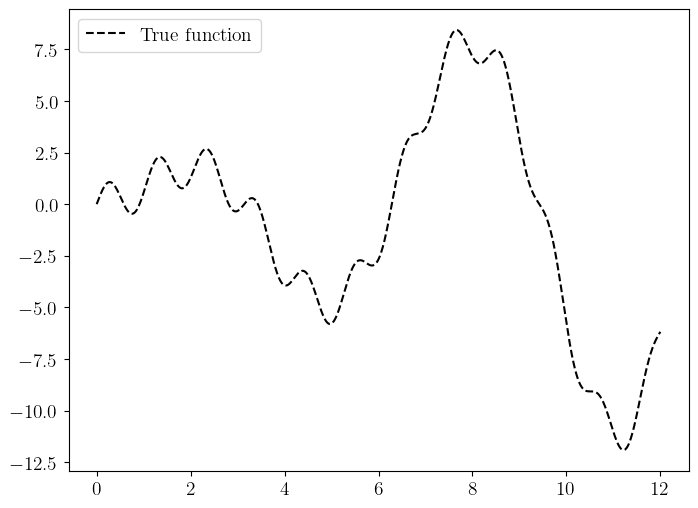

In [5]:
plt.figure(figsize=(8, 6))
plt.plot(x_node, y_true, color='k', linestyle='dashed', label='True function')
plt.legend(loc='best');

In [6]:
n = 5
distribution = ot.Normal(6., 1.)
#x_train = distribution.getSample(5)
#x_train = np.array([1.2, 2., 5., 8.2, 10.]).reshape(-1, 1)
x_train = np.array([1.2, 2., 5., 6.5, 8.2, 10.]).reshape(-1, 1)
#x_train = np.array([1.2, 3., 6.5, 10.]).reshape(-1, 1)
y_train = g(x_train)

In [7]:
kriging_results = ctb.CentralTendencyBenchmark().build_kriging(x_train, y_train)
predictor = kriging_results.getMetaModel()
y_predictor = np.array(predictor(nodes)).flatten()

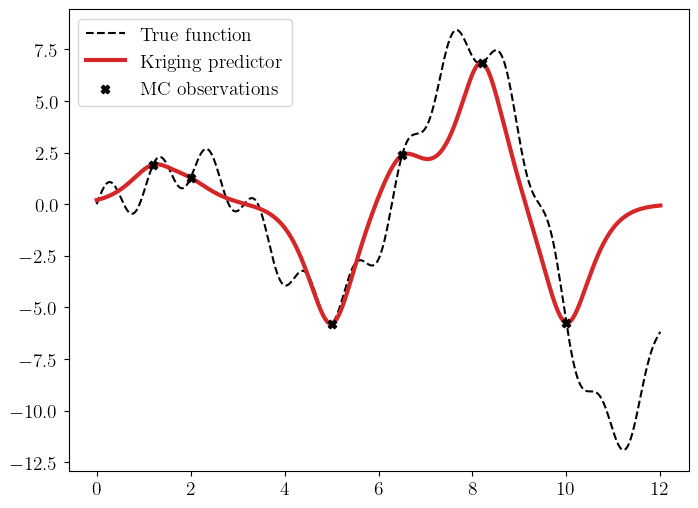

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(x_node, y_true, color='k', linestyle='dashed', label='True function', zorder=0)
plt.plot(x_node, y_predictor, color='C3', linewidth=3, label='Kriging predictor', zorder=1)
plt.scatter(x_train, y_train, marker='X', color='k', label='MC observations', zorder=2)
plt.legend(loc='best');

## Simulate new trajectories

In [9]:
process = ot.ConditionedGaussianProcess(kriging_results, mesh)
trajectories_nb = 1000
trajectories = process.getSample(trajectories_nb)

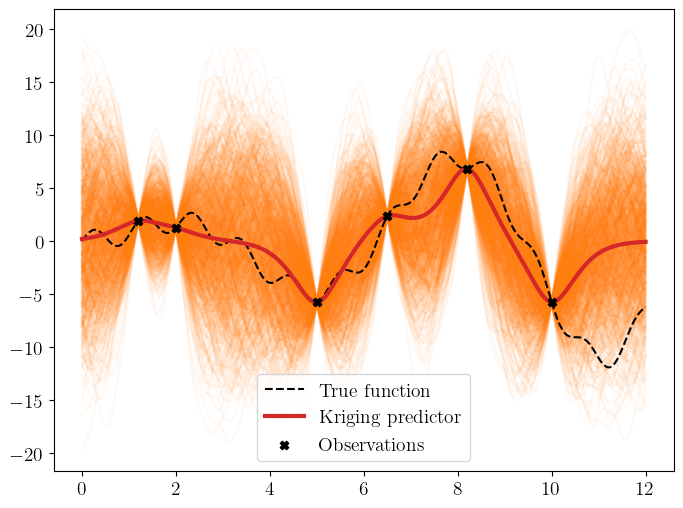

In [10]:
plt.figure(figsize=(8, 6))
for t in range(trajectories_nb):
    traj = np.array(trajectories.getMarginal(0)[t]).flatten()
    plt.plot(x_node, traj, color='C1', alpha=0.05, zorder=0)

plt.plot(x_node, y_true, color='k', linestyle='dashed', label='True function', zorder=1)
plt.plot(x_node, y_predictor, color='C3', linewidth=3, label='Kriging predictor', zorder=2)
plt.scatter(x_train, y_train, marker='X', color='k', label='Observations', zorder=3)
plt.legend(loc='best');

In [11]:
m = 128
sobol_sample = ctb.DesignOfExperiments().sobol_sample(m, distribution)
sample_pred = predictor(sobol_sample)
sample_covariance_matrix = kriging_results.getConditionalCovariance(sobol_sample)
sample_variance = np.array(kriging_results.getConditionalMarginalVariance(sobol_sample))

In [12]:
inputRandomVector = ot.RandomVector(distribution)
compositeRandomVector = ot.CompositeRandomVector(g, inputRandomVector)
ref_sample = compositeRandomVector.getSample(int(1e6))
ref_mean = ref_sample.computeMean()[0]
ref_mean

-0.4271840302615227

In [13]:
reals = []
for i in range(m) :
    reals.append(ot.Normal(sample_pred[i][0], np.sqrt(sample_variance[i][0])))

In [14]:
reals_sum = reals[0]
for real in reals:
    reals_sum += real
reals_sum = reals_sum / m

In [15]:
reals_sum.getMean()[0]

-0.31768756617277444

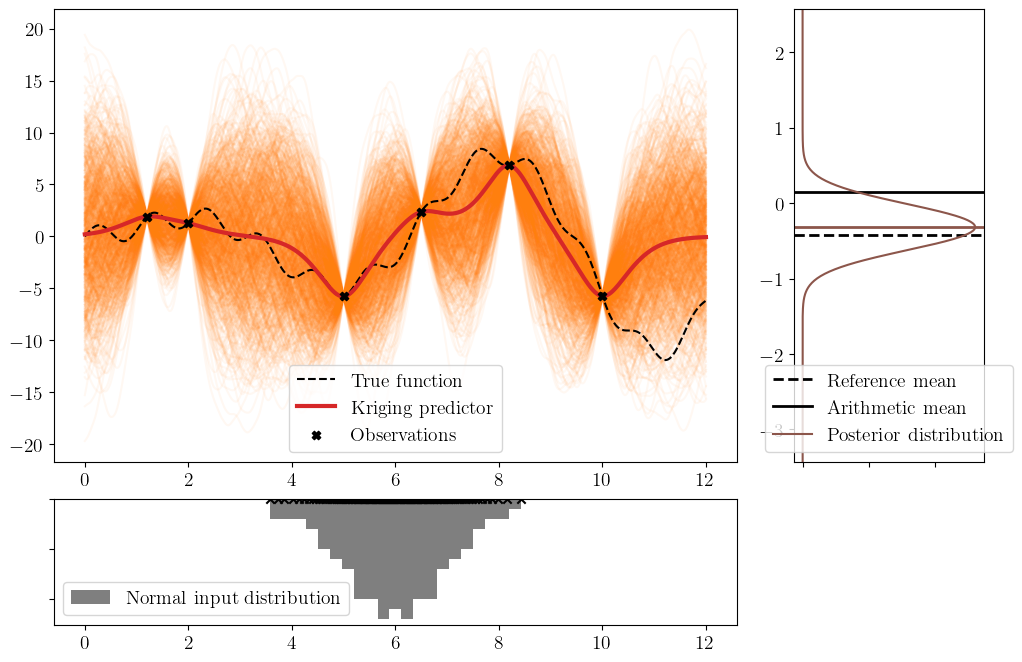

In [16]:
fig = plt.figure(figsize=(12 ,8))
grid = plt.GridSpec(4, 4, hspace=0.3, wspace=0.3)
main_ax = fig.add_subplot(grid[:-1, 0:-1])
#y_hist = fig.add_subplot(grid[:-1, -1], xticklabels=[], sharey=main_ax)
y_hist = fig.add_subplot(grid[:-1, -1], xticklabels=[])
x_hist = fig.add_subplot(grid[-1, 0:-1], yticklabels=[], sharex=main_ax)
# GP plotting with 1000 random trajectories
for t in range(trajectories_nb):
    traj = np.array(trajectories.getMarginal(0)[t]).flatten()
    main_ax.plot(x_node, traj, color='C1', alpha=0.05, zorder=0)

main_ax.plot(x_node, y_true, color='k', linestyle='dashed', label='True function', zorder=1)
main_ax.plot(x_node, y_predictor, color='C3', linewidth=3, label='Kriging predictor', zorder=2)
main_ax.scatter(x_train, y_train, marker='X', color='k', label='Observations', zorder=3)
main_ax.legend(loc='best')

# histogram on the attached axes
x_hist.scatter(sobol_sample, [0] * m, zorder=2, marker='x', color='k')
x_hist.hist(sobol_sample, m//6, orientation='vertical', color='C7', label='Normal input distribution')
x_hist.invert_yaxis()
x_hist.legend(loc='best')


x_norm = np.arange(ref_mean - 5, ref_mean + 5, 0.01).reshape(-1, 1)
pdf_norm = reals_sum.computePDF(x_norm)
y_hist.axhline(y=ref_mean, color='k', linestyle='dashed', linewidth=2 , label="Reference mean")
y_hist.axhline(y=np.mean(y_train), color='k', linewidth=2 , label="Arithmetic mean")
y_hist.axhline(y=reals_sum.getMean()[0], linewidth=2, color='C5')

y_hist.plot(pdf_norm, x_norm, color='C5', label='Posterior distribution')

y_hist.legend(loc='lower center')
#y_hist.set_ylim([-3., 3.])
y_hist.set_ylim([ref_mean - 3., ref_mean + 3])
plt.savefig('figures/posterior_distribution_centered.pdf', bbox_inches='tight');